# PyMC3: first baby steps towards Bayesian inference

This notebook shows the use of PyMC3 to do a linear regression the bayesian way, including some comparison to the good-old frequentist inference way.

Stuff that is imported includes:
- PyMC3: the probabilistic programming package that helps you out when trying to be a good Bayesian
- ArviZ: a package related to PyMC3 (but also compatible with other popular bayesian tools like stan, emcee, tensorflow probability and numpyro
- the usual suspects: numpy, pandas, matplotlib/seaborn
- statsmodels and scikit-learn are imported for the comparison.

On the background, PyMC3 uses theano, for lazy evaluated compute graphs. At some point in the near future, these might be taken care of by JAX, and with that be even faster still.


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import pymc3 as pm

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

print('Running on PyMC3 v{}'.format(pm.__version__))

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

Running on PyMC3 v3.9.3


## Creating a fake data set to work with

A fake, and rather un-inspiring data set is created on top of which we want to do linear regression. The data is quite suitable for that, indeed. A linear relation between x and y, with gaussian scatter is created, so that after regression the recovered variables can be compared to the original ones.

In [2]:
size = 200
true_intercept = 4
true_slope = 6

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

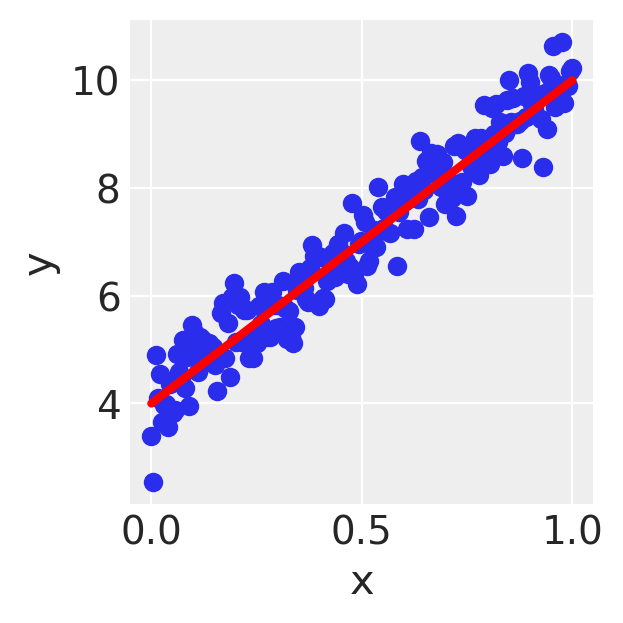

In [3]:
# Here's what it looks like
plt.figure(figsize=(3,3))
plt.scatter(x, y)
plt.plot(x, true_regression_line, color='red', linewidth=3)
plt.xlabel('x'); plt.ylabel('y');

## Linear regression with statsmodels and sklearn as an example

First we will do a maximum likelihood point estimate of the slope and intercept using two popular frequentist packages: statsmodels and sklearn. Code like this should be rather familiar.

In [4]:
# Statsmodels requires one to specify the extra constant that needs to be fitted and can then fit using Ordinary Least Squares
X = sm.add_constant(x, prepend=True)
smreg = sm.OLS(y, X)
smres = smreg.fit()
# After fitting, an extensive summary of fit results can be produced.
smres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3011.
Date:                Mon, 09 Nov 2020   Prob (F-statistic):          1.01e-121
Time:                        17:04:06   Log-Likelihood:                -125.37
No. Observations:                 200   AIC:                             254.7
Df Residuals:                     198   BIC:                             261.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9898      0.064     62.211      0.000       3.863       4.116
x1             6.0879      0.111     54.874      0.000       5.869       6.307
==============================================================================
Omnibus:                        0.699   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.705   Jarque-Bera (JB):                0.767
Skew:                          -0.138   Prob(JB):                        0.682
Kurtosis:                       2.873   Cond. No.                         4.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
# Different syntax, similar results using sklearn
regr = LinearRegression()
regr.fit(x.reshape(-1,1), y)
print(f'Slope {regr.coef_[0]:3.2f} and intercept {regr.intercept_:3.2f}')

Slope 6.09 and intercept 3.99


As can be seen, and as was expected the recovered slope and intercept are similar to the input values, and to each other. Statsmodels by default gives you a lot of statistics as well, in sklearn that takes some more effort (e.g. the uncertainity on the slope and intercept are not calculated for you). Remember that machine learning is not after getting information on the parameters, but after future predictions. The latter are easier with sklearn than with statsmodels.

## On to the Bayesian way.

In order to do this same exercise using PyMC3 there are a couple of things you need to know about this package for probabilistic programming:
- Everything happens within the context of a model
- You need to define a "generative model" that describes how your data are generated, based on stochastic variables (and perhaps some deterministic variables)
- For those stochastic variables you need to define a prior: a distributino function describing your "prior belief" about the variables, which will get updated by the data into the posterior distribution functions (i.e. for every prior, you will get a posterior
- This posterior is sampled by a sampling algorithm, in order to know the full posterior probablility density, not just a point estimate of maximum likelihood.

Let's see how that goes:

In [6]:
with pm.Model() as linreg: # model specifications in PyMC3 are wrapped in a context
    # Define priors
    # These priors are pretty uninformative: wide distributions without any peaks, the stochastic variables can be anywhere
    # They are defined using PyMC3 definied probability distribution functions (and corresponding parameters) and they get a name
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('Slope', 0, sigma=20)

    # Define likelihood: a PDF as well, that depends on the stochastic variables for which you defined a prior
    # The observed=-keyword specifies that this is the observed data that is being described by the model
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)

    # Inference! The posterior PDF will be sampled
    trace = pm.sample(5000, cores=2, tune=2000) # draw 3000 posterior samples using NUTS sampling



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Slope, Intercept, sigma]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.7153382146723232, but should be close to 0.8. Try to increase the number of tuning steps.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept  3.989  0.067   3.863    4.110      0.001    0.001    3893.0   
Slope      6.089  0.115   5.877    6.304      0.002    0.001    3970.0   
sigma      0.458  0.024   0.417    0.506      0.000    0.000    4606.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept  3893.0    3907.0    4055.0    1.0  
Slope      3969.0    3970.0    4215.0    1.0  
sigma      4606.0    4469.0    3543.0    1.0  


<Figure size 700x700 with 0 Axes>

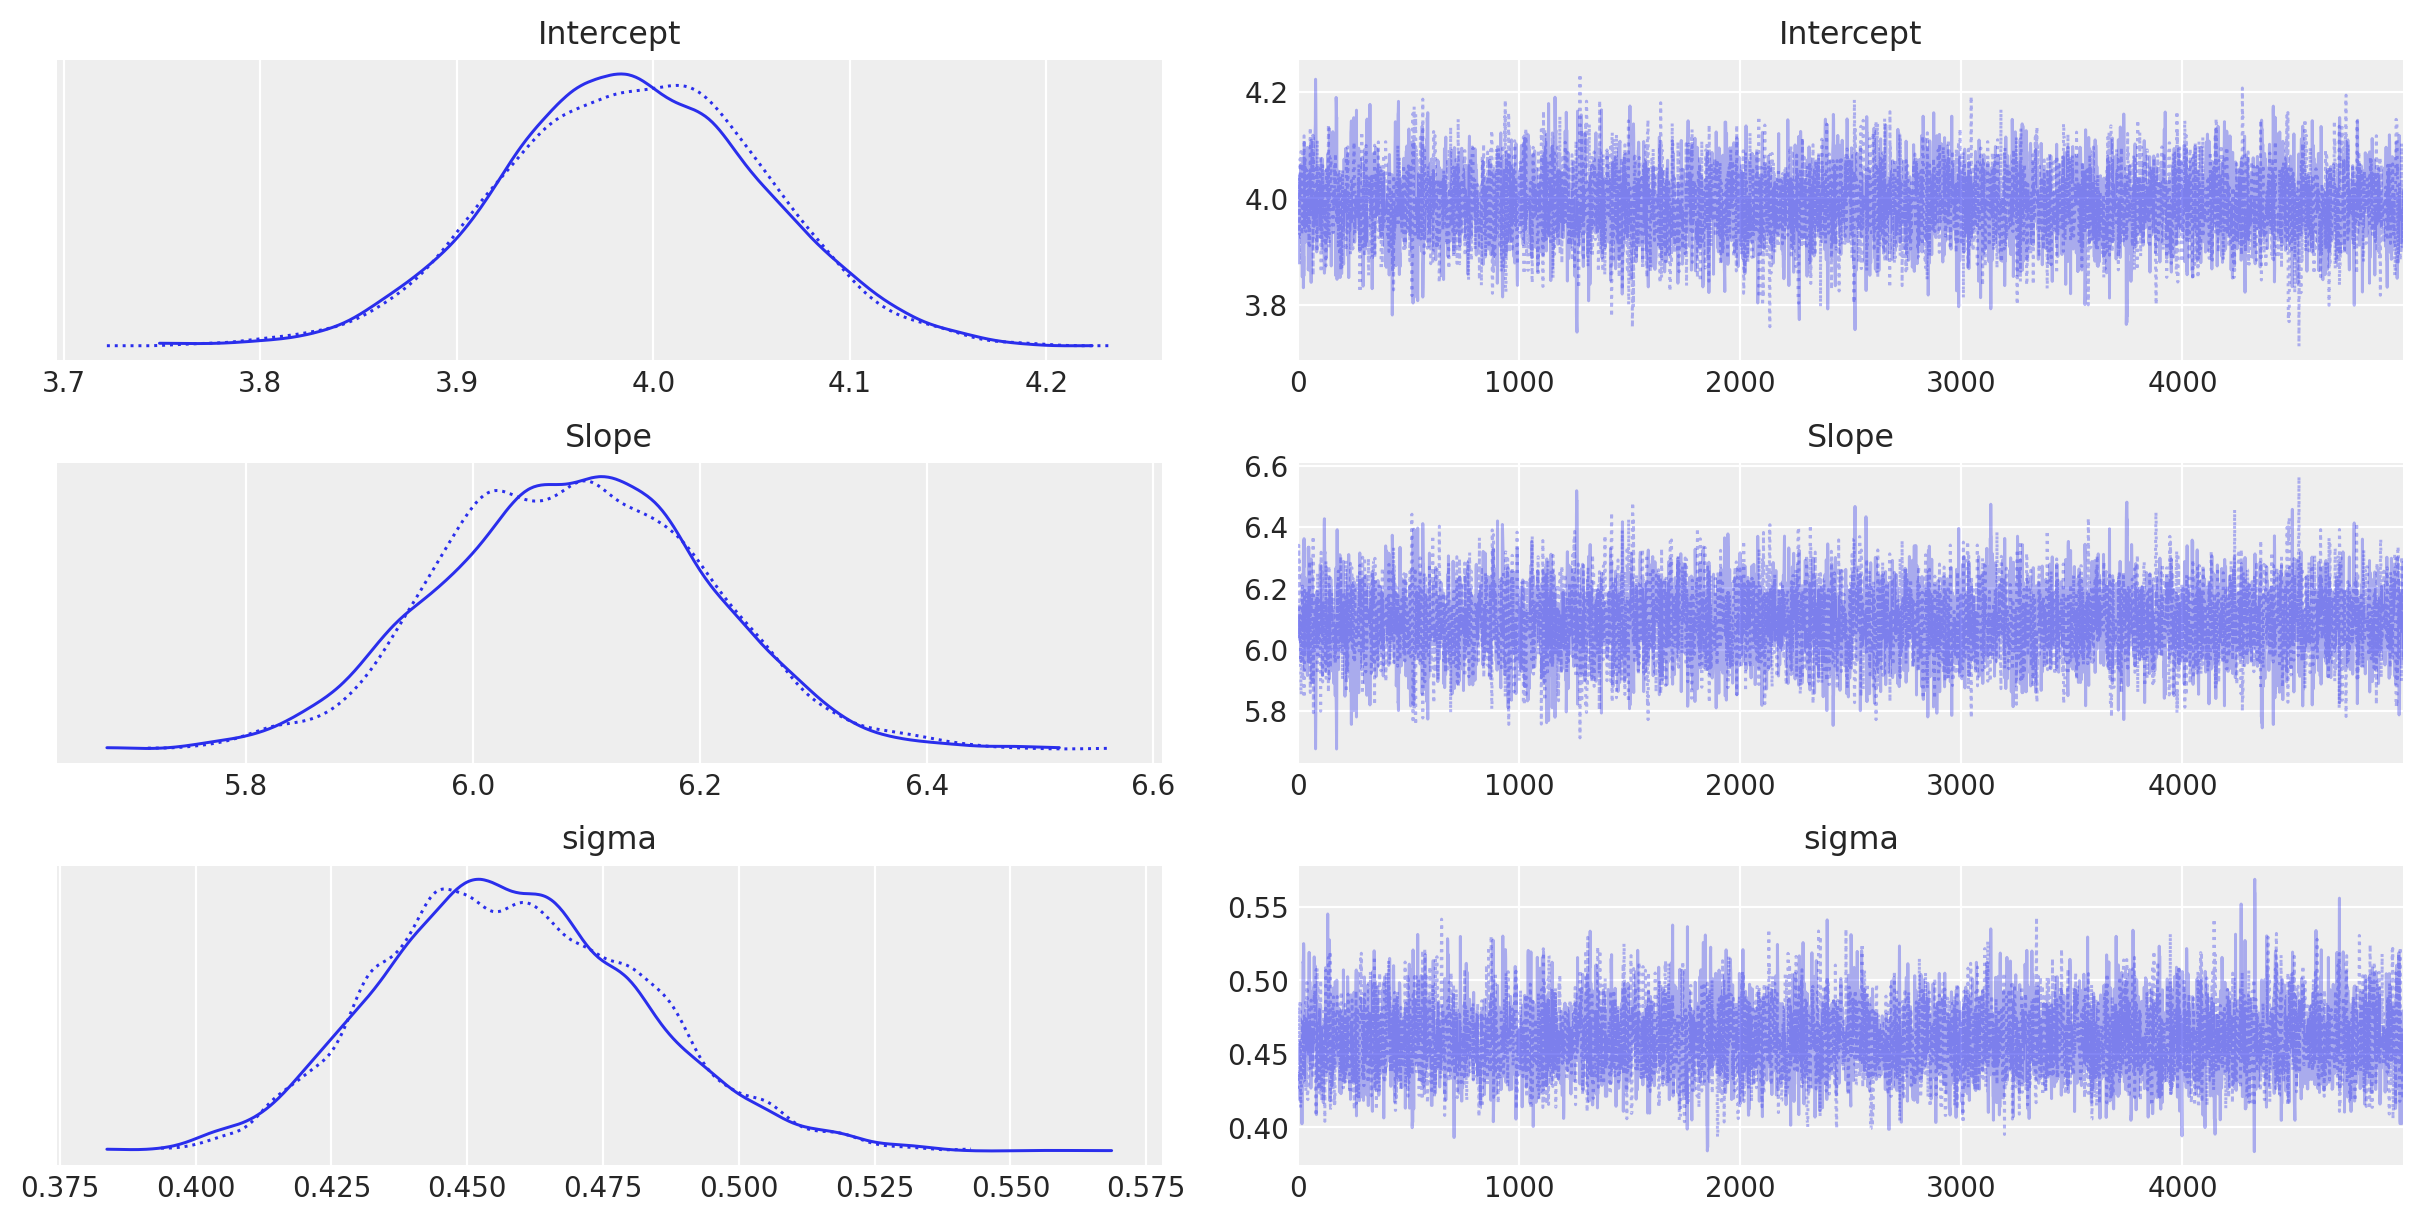

In [7]:
# After the inference we can get back into the model context and do more, like investigating results
with linreg:
    plt.figure(figsize=(7,7))
    print(pm.summary(trace)) # A summary of the results for all stochastic variables
    pm.traceplot(trace); # This comes from arviz, called by pymc3 and shows traces and marginal posterior PDFs
    

On the left, you see the marginal posterior PDFs for all stochastic variables. The two lines are for the two chains (two independent Markov Chains were used to sample the posterior). To the right you see the "traces", which describe how the value of the variables was jumping up and down while sampling. The reason to plot that trace is that you want it to be flat and fuzzy, not bending up or down, no "flat" region where it isn't varying, becasue all such things would indicate that there was an issue while sampling.

You can use samples from the posterior (points along the trace) to in fact "predict" values like you would when doing machine learning:

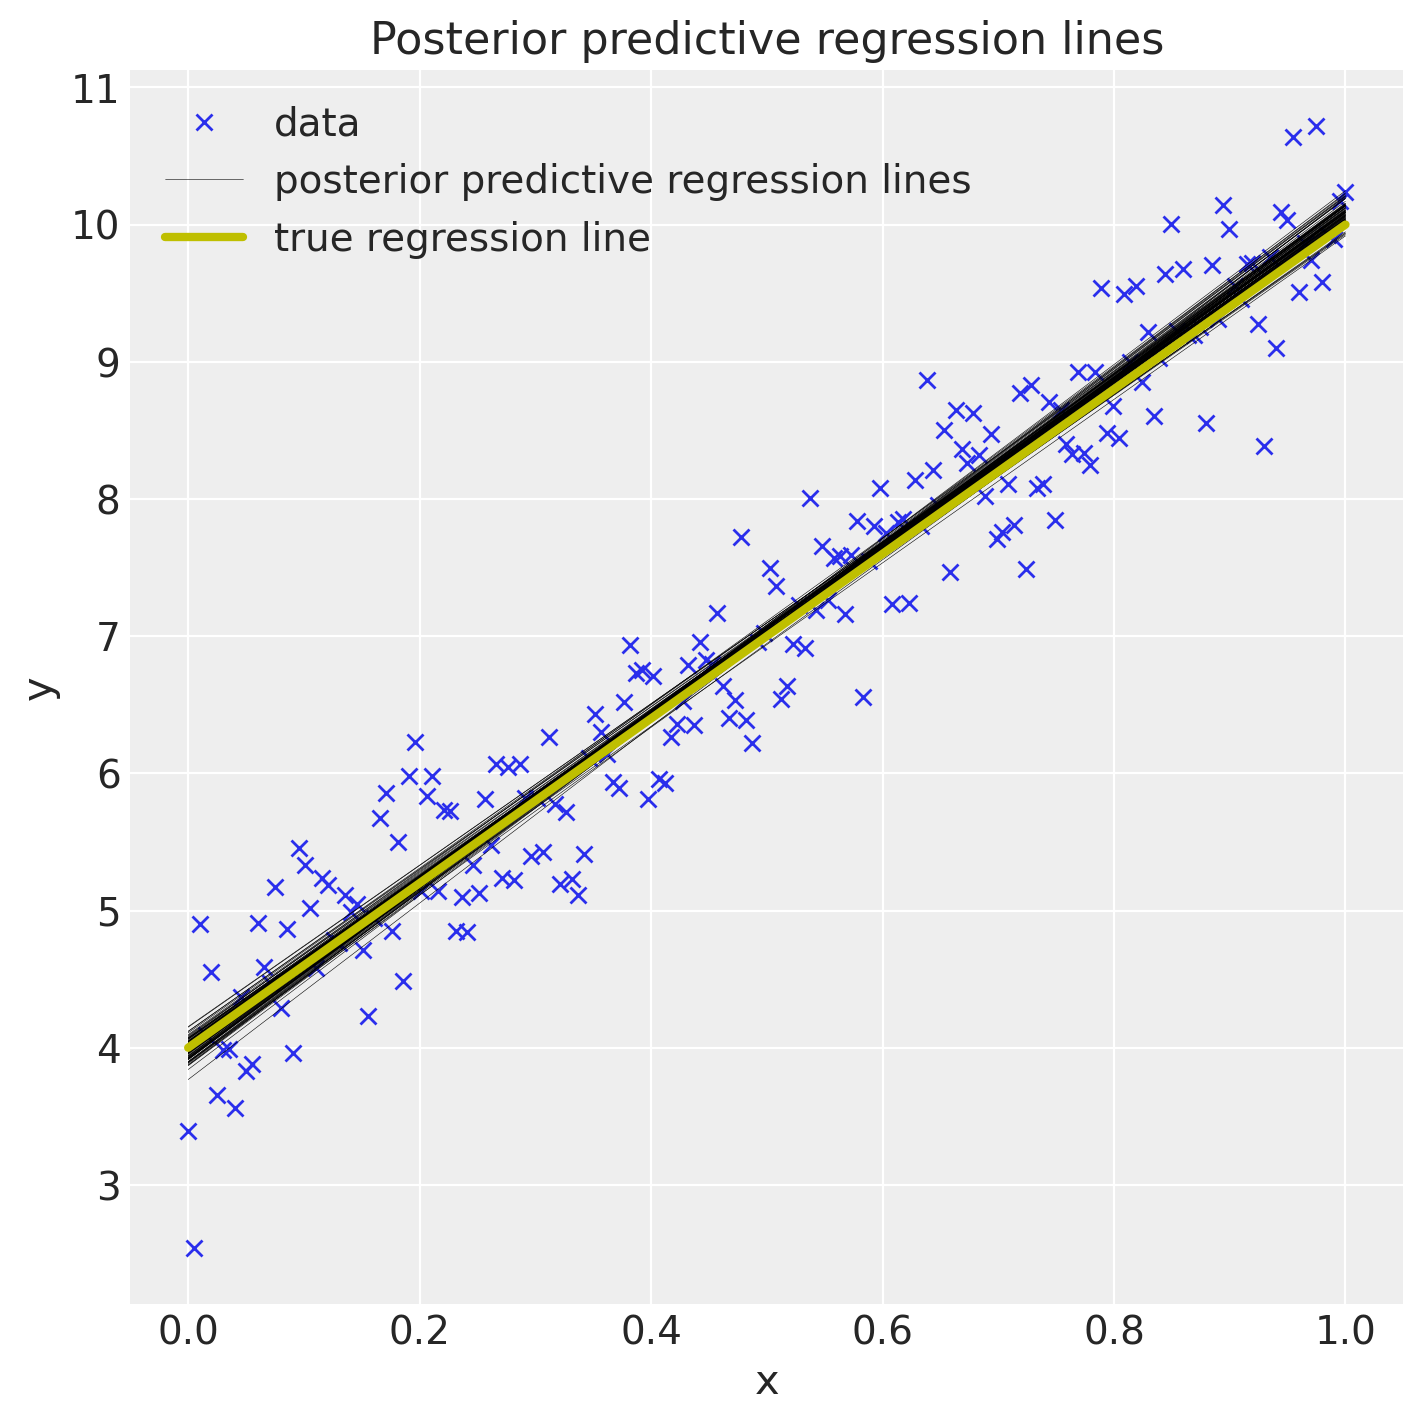

In [8]:
# We can also sample the posterior to plot a bunch of reasonable fits, according to the posterior PDF
with linreg:
    plt.figure(figsize=(7, 7))
    plt.plot(x, y, 'x', label='data')
    # Again, kindly provided by arviz, called from pymc3:
    pm.plot_posterior_predictive_glm(trace, samples=100, lm=(lambda  x, sample: sample['Intercept'] + sample['Slope'] * x),
                                  label='posterior predictive regression lines')
    plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

    plt.title('Posterior predictive regression lines')
    plt.legend(loc=0)
    plt.xlabel('x')
    plt.ylabel('y');


One might say that this method of doing regression is very expensive. The MCMC sampling takes a lot longer than the statsmodels and sklearn fits before. This would be true. But besides this framework being much more general (meaning you can fit a whole slew of very complicated models in basically the same way), you also get some extra result for free, that you don't get from the frequentist models.

When doing a linear fit on a data set like this, there is an anti-correlation between the slope and the intercept. This is easy to understand: if you pick your intercept "too high", you would need a shallower slope to still fit your data. Plotting the joint posterior PDFs makes that point clear immediately:

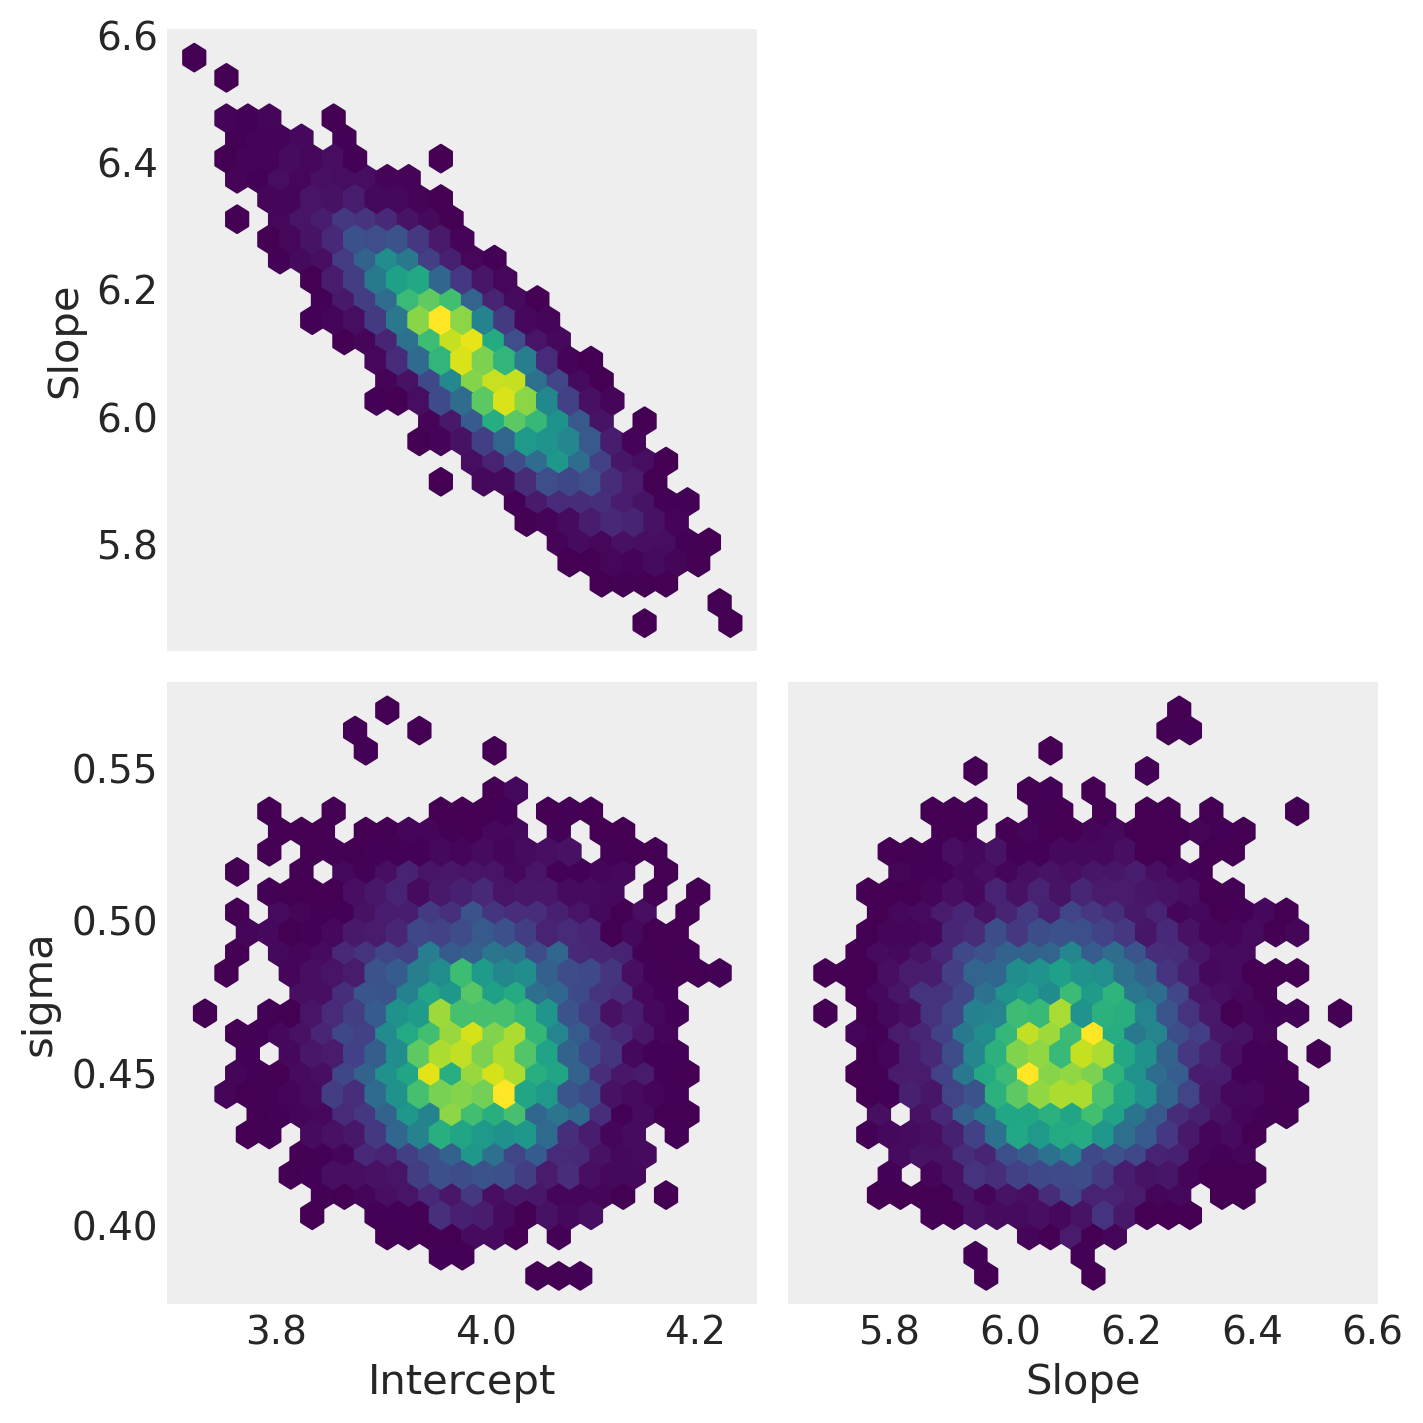

In [9]:
# You can also look at the joint PDFs of the involved stochastic variables, which gives nice insights
with linreg:
    pm.pairplot(trace, kind='hexbin', figsize=(7,7))

The top plot shows the anti-correlation. We can also show only this part and the marginal PDFs alongside with seaborn:

/home/marcel/anaconda3/envs/bayes/lib/python3.8/site-packages/seaborn/axisgrid.py:1629: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


<Figure size 600x600 with 0 Axes>

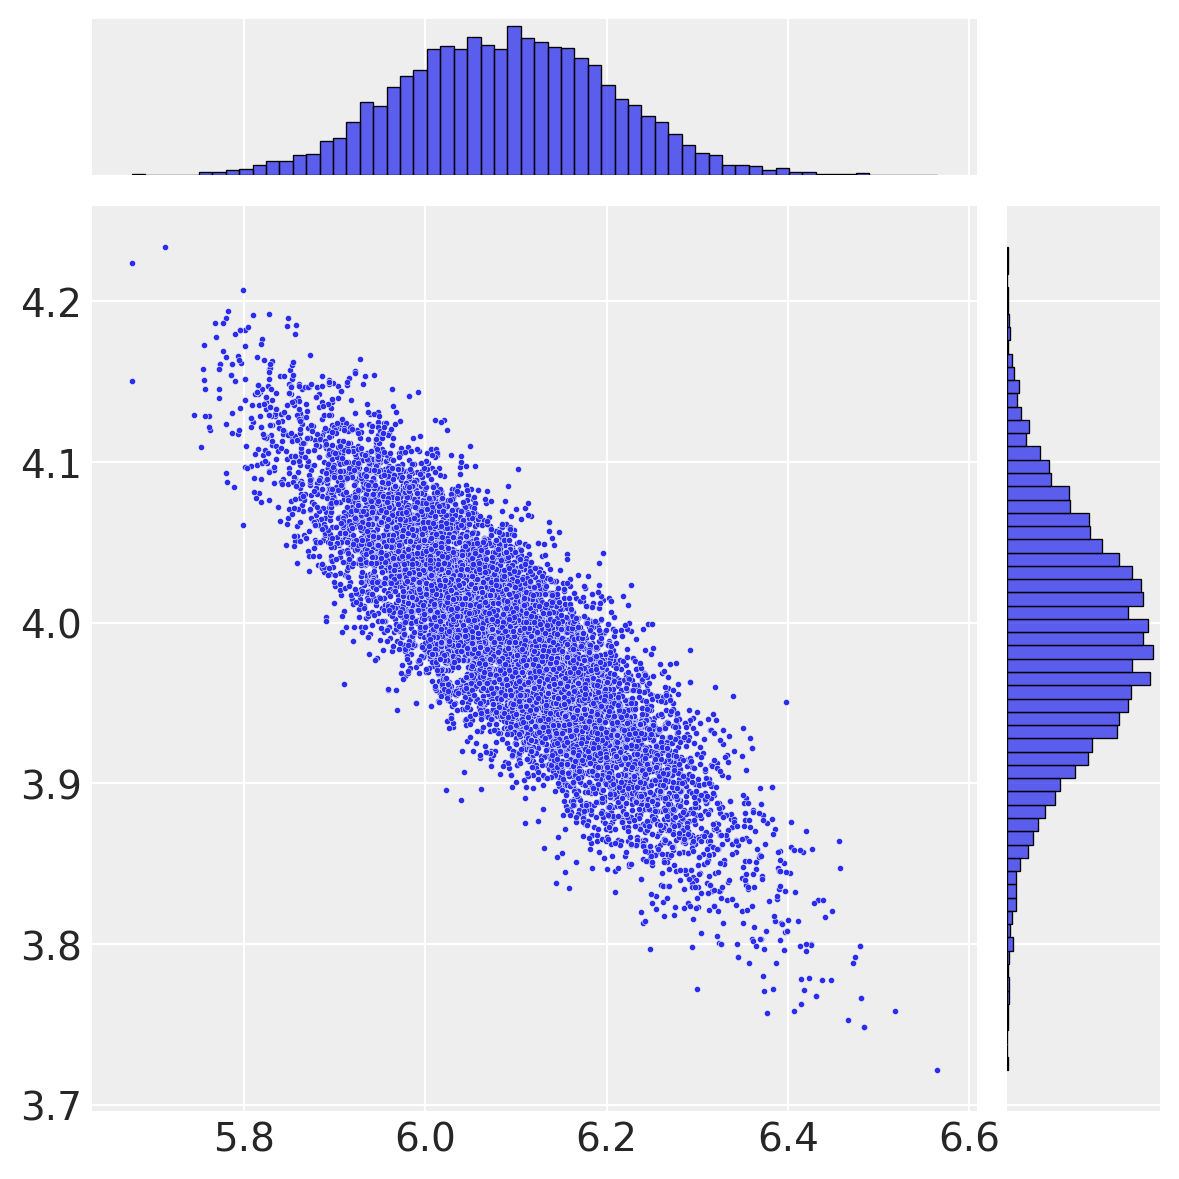

In [10]:
with linreg:
    plt.figure(figsize=(6,6))
    sns.jointplot(x=trace['Slope'], y=trace['Intercept'], s=5);

The marginal PDFs look nicely gaussian, and their standard deviations are in fact very similar to those reported by statsmodels. Nevertheless, without knowing about this joint PDF, sampling from both independently would result in linear fits that do not occur in this posterior (and it can be argued that taking only results from this posterior is what you want)!

Obviously, the "best fit" (taking the mean or median from the posterior) is going to result in the same as the frequentist approach.

There are many advantages of using this bayesian methods, among which there are:
- Bayesian methods answer the right question ("what is my knowledge about the model given the data?" rather than the frequentist question "how likely is my data given my model?"); a philosohpical point, but not an unimportant one.
- Bayesian methods give you the full posterior PDF, also for nuisance parameters (parameters that you are not interested in, but do affect the generative model), over which you can then easily marginalize.
- This bayesian method requires you to think about the generative model of your data, which is a natural path towards inference.

In a future episode I will dive into more complicated models, which should give the average frequentist headaches! 

A great set of **references** in "literature", at least that I like are:
- [A blog series](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake VanderPlas.
- [A nice PyMC3 tutorial](https://www.youtube.com/watch?v=SS_pqgFziAg) by BDFL Chris Fonnesbeck.
- [A fun podcast: Learning Bayesian Statistics](https://learnbayesstats.anvil.app/) by Alex Andorra.
- [The official PyMC3 tutorials](https://docs.pymc.io/nb_tutorials/index.html).
- [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3) by Cameron Davidson-Pilon (PyMC3 version).



*By Marcel Haas, Nov 9, 2020*

*datascience@marcelhaas.com*